In [2]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
from qiskit import quantum_info as qi 
import numpy as np

In [3]:
import import_ipynb
import Draper_adder

In [ ]:
def oracle(n,c0,c1):
    c = QuantumRegister(1,'c')
    k = QuantumRegister(n,'k')
    P0 = QuantumRegister(n,'P0')
    P1 = QuantumRegister(n,'P1')
    ancilla = QuantumRegister(1,'anc')

    qc=QuantumCircuit(P0,P1,ancilla,name="Oracle")

    # Compute flips
    for i in range(n):
        if(c0[i]==0):
            qc.x(P0[n-i-1])
        if(c1[i]==0):
            qc.x(P1[n-i-1])

    qc.mcx(P0[:] + P1[:],ancilla[0])
    

    #uncompute filps
    for i in range(n):
        if not c0[i]: qc.x(P0[n-i-1])
        if not c1[i]: qc.x(P1[n-i-1])

    return qc.to_gate()

In [ ]:
def diffusion(n):
    k = QuantumRegister(n,'k')

    qc = QuantumCircuit(k,name="Diffusion")

    
    qc.h(k[:])
    qc.x(k[:])
    qc.h(k[n-1])
    qc.mcx(k[:n-1], k[n-1])
    qc.h(k[n-1])
    qc.x(k[:])
    qc.h(k[:])
    

    return qc.to_gate()

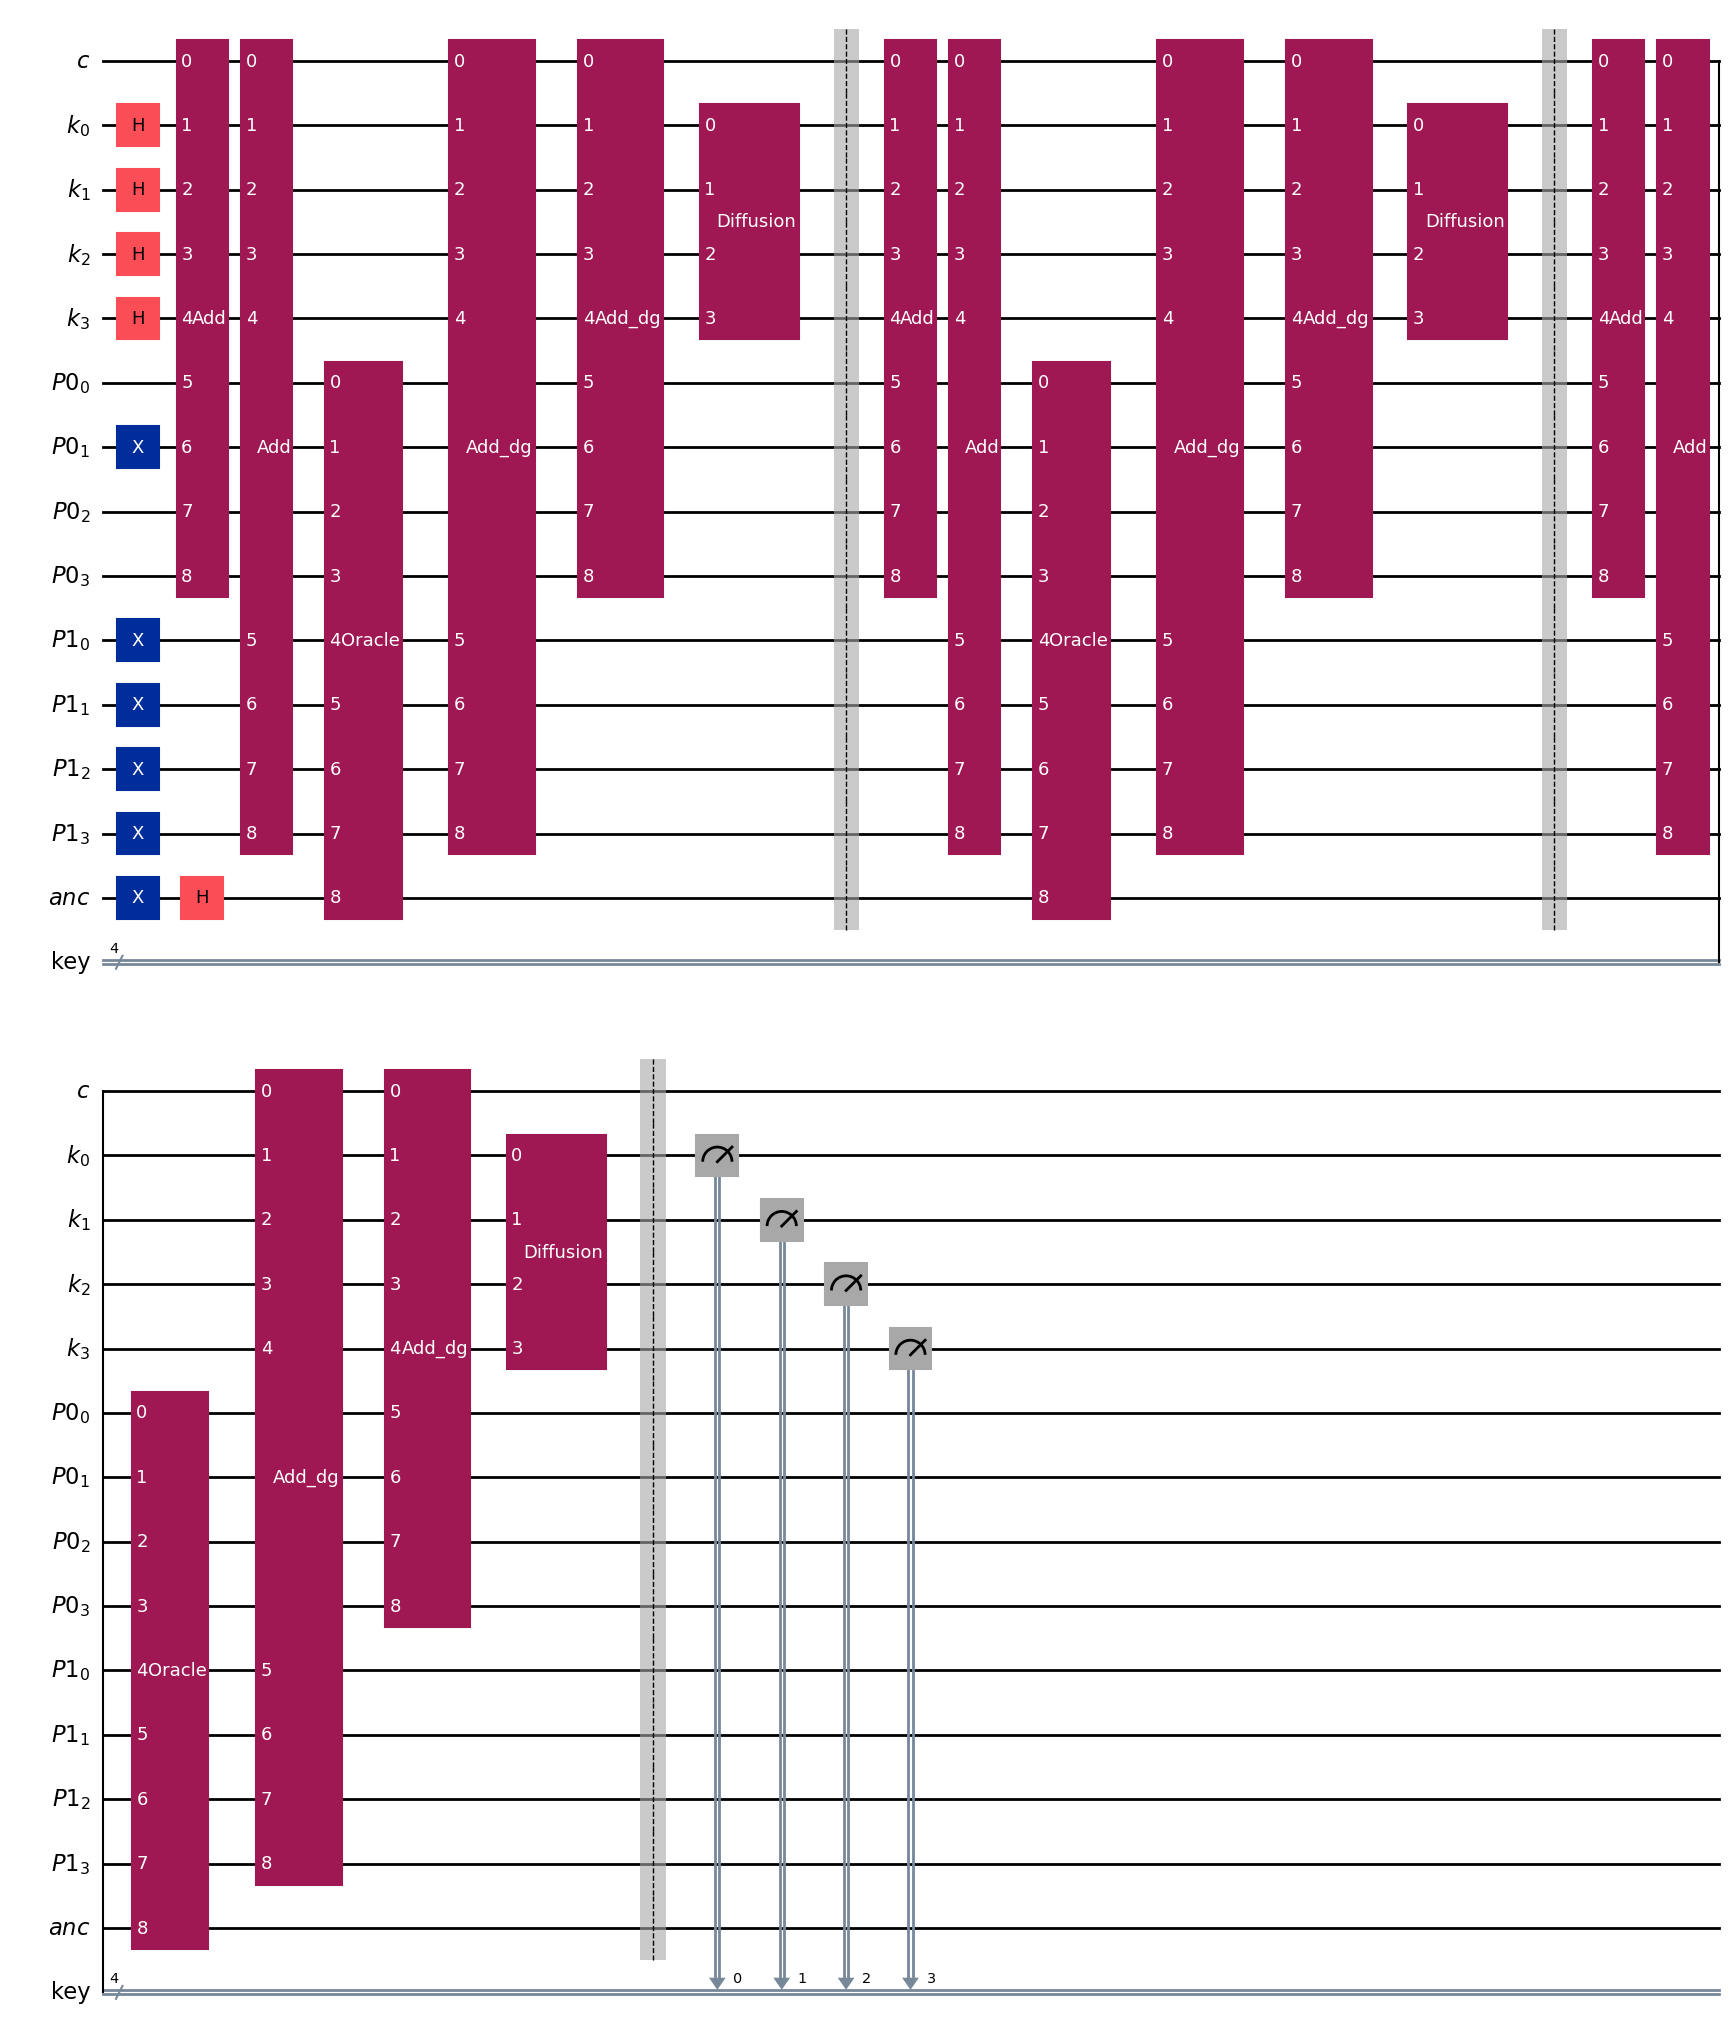

In [6]:
p0 = [0,0,1,0] #plain text
p1 = [1,1,1,1]

c0 = [0,1,0,0] #cipher text
c1 = [0,0,0,1]

n = 4
mu = 1 #No. of solutions(k = [0,0,1,0] = 2)

r = int(np.floor(np.pi/4*np.sqrt(2**(n)/mu))) 

c = QuantumRegister(1,'c')
k = QuantumRegister(n,'k')
P0 = QuantumRegister(n,'P0')
P1 = QuantumRegister(n,'P1')
ancilla = QuantumRegister(1,'anc')
# cipher = ClassicalRegister(n,'cipher')
key = ClassicalRegister(n,'key')

qc=QuantumCircuit(c,k,P0,P1,ancilla,key)

for i in range(n):
    # qc.x(k[i])
    qc.h(k[i])



for i in range(n):
    if(p0[i]==1):
        qc.x(P0[n-i-1])
    if(p1[i]==1):
        qc.x(P1[n-i-1])

qc.x(ancilla[0])
qc.h(ancilla[0])

for _ in range(r):
    qc.append(Draper_adder.adder(n),[c[0]]+k[:]+P0[:])
    qc.append(Draper_adder.adder(n),[c[0]]+k[:]+P1[:])

    # Oracle
    qc.append(oracle(n,c0,c1),P0[:]+P1[:]+[ancilla[0]])
    # qc.barrier()
    qc.append(Draper_adder.adder_dag(n),[c[0]]+k[:]+P1[:])
    qc.append(Draper_adder.adder_dag(n),[c[0]]+k[:]+P0[:])

    # diffusion operator
    qc.append(diffusion(n),k[:])
    
    
    qc.barrier()

for i in range(n):
    # qc.measure(P1[i],key[i])
    qc.measure(k[i],key[i])

# for i in range(n):
#     qc.measure(P1[i],key[i])
#     # qc.measure(k[i],key[i])

qc.draw('mpl')

measurement counts: {'0010': 1}


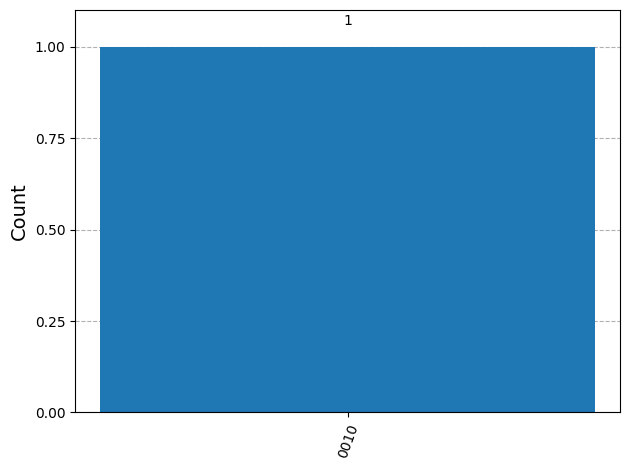

In [7]:
#local simulator

from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
compiled_circuit = transpile(qc,simulator)

result = simulator.run(compiled_circuit, shots=1).result()

counts = result.get_counts()
print("measurement counts:",counts)
plot_histogram(counts)

In [84]:
qi.Statevector(qc).draw('latex')

<IPython.core.display.Latex object>